# COS711 - Assignment 2
# Hybrid Learning in Neural Networks for Almond Classification
### Jake Weatherhead (u04929552)  

In [1]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from torch.utils.data import TensorDataset, DataLoader
from sklearn.decomposition import PCA, TruncatedSVD
from torch.optim.optimizer import Optimizer
from sklearn.impute import KNNImputer
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
from scipy import stats
import seaborn as sns
import torch.nn as nn
import pandas as pd
import numpy as np
import random
import torch # v2.4.0+cu121
import math

Define ANOVA (**AN**alysis **O**f **VA**riance) function for statistical significance tests

In [2]:
def anova_test(test_results):
    """
    One-way ANOVA test on multiple groups of data to determine if there is any 
    statistically significant difference between the means of the groups.

    Null hypothesis (H0): no differences among the group means and they are all equal. 
    
    Alternative hypothesis (H1): at least one group mean is different from the others.
    """
    data_arrays = [np.array(lst) for lst in test_results]
    f_stat, p_value = stats.f_oneway(*data_arrays)

    if p_value < (alpha := 0.05):
        return f"Reject the null hypothesis: F-stat = {f_stat}, p-value = {p_value}"
    else:
        return f"Fail to reject the null hypothesis: F-stat = {f_stat}, p-value = {p_value}"


Define Tukey honest significant difference (Tukey-HSD) function for statistical significance tests

In [3]:
def tukey_post_hoc(test_results):
    """
    Conducts a Tukey's Honest Significant Difference (HSD) test on a flattened list of group results to determine 
    if there are any statistically significant differences between the means of any pair of groups.

    Null hypothesis (H0): for each pair under comparison there is no difference between the means of the pair. 
    
    Alternative hypothesis (H1): there is a difference between the means of the pair under comparison.
    """
    test_results_flat = np.concatenate(test_results)
    groups = np.array([[f"Group {i+1}"] * len(test_results[i]) for i in range(len(test_results))]).flatten()
    tukey_results = pairwise_tukeyhsd(test_results_flat, groups, alpha=0.05)
    return tukey_results.summary()

Define paired t-test function for statistical significance tests

In [4]:
def paired_t_test(test_results):
    """
    Performs a paired t-test on two related groups of data to determine if there is a statistically 
    significant difference between their means.

    Null hypothesis (H0): the mean difference between the paired observations is zero. 
    Alternative hypothesis (H1): the mean difference between the paired observations is not zero.
    """
    lst1 = np.array(test_results[0])
    lst2 = np.array(test_results[1])
    
    t_stat, p_value = stats.ttest_rel(lst1, lst2)
    
    if p_value < (alpha := 0.05):
        return f"Reject the null hypothesis t_stat: {t_stat}, p-value: {p_value}"
    return f"Fail to reject the null hypothesis t_stat: {t_stat}, p-value: {p_value}"

Define helper function for statistical significance reporting

In [5]:
def calculate_stats(data_lst):
    """
    Calculates mean and standard deviation of a single trial
    """
    mean = round(sum(data_lst) / len(data_lst), 3)
    variance = sum((x - mean) ** 2 for x in data_lst) / len(data_lst)
    std_dev = round(math.sqrt(variance), 3)
    return mean, std_dev

### Data Exploration and Processing

In [6]:
df = pd.read_csv('data/Almond.csv')

In [7]:
df.head()

,Unnamed: 0,Length (major axis),Width (minor axis),Thickness (depth),Area,Perimeter,Roundness,Solidity,Compactness,Aspect Ratio,Eccentricity,Extent,Convex hull(convex area),Type
0,0,NaN,227.940628,127.759132,22619.0,643.813269,NaN,0.973384,1.458265,NaN,NaN,0.681193,23237.5,MAMRA
1,1,NaN,234.188126,128.199509,23038.0,680.984841,NaN,0.957304,1.601844,NaN,NaN,0.656353,24065.5,MAMRA
2,2,NaN,229.418610,125.796547,22386.5,646.943212,NaN,0.967270,1.487772,NaN,NaN,0.683620,23144.0,MAMRA
3,3,NaN,232.763153,125.918808,22578.5,661.227483,NaN,0.965512,1.540979,NaN,NaN,0.685360,23385.0,MAMRA
4,4,NaN,230.150742,107.253448,19068.0,624.842706,NaN,0.951450,1.629395,NaN,NaN,0.714800,20041.0,MAMRA


Drop irrelevant feature

In [8]:
df.drop(columns=['Unnamed: 0'], inplace=True)

List unique Almond-types (labels)

In [9]:
list(df['Type'].unique()) 

['MAMRA', 'SANORA', 'REGULAR']

In [10]:
def detect_outliers(df):
    outliers = {}
    for column in df.select_dtypes(include=['float64', 'int64']).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outlier_count = df[(df[column] < lower_bound) | (df[column] > upper_bound)].shape[0]
        outliers[column] = outlier_count
        
    return outliers

detect_outliers(df)

{'Length (major axis)': 16,
 'Width (minor axis)': 9,
 'Thickness (depth)': 22,
 'Area': 87,
 'Perimeter': 61,
 'Roundness': 0,
 'Solidity': 208,
 'Compactness': 209,
 'Aspect Ratio': 53,
 'Eccentricity': 8,
 'Extent': 112,
 'Convex hull(convex area)': 89}

Get number of missing values per feature

In [11]:
df.isnull().sum() 

Length (major axis)          857
Width (minor axis)           942
Thickness (depth)           1004
Area                           0
Perimeter                      0
Roundness                    857
Solidity                       0
Compactness                    0
Aspect Ratio                1799
Eccentricity                1799
Extent                         0
Convex hull(convex area)       0
Type                           0
dtype: int64

The majority of the rows in the dataset contain missing values for the 'Aspect Ratio' and 'Eccentricity' features.

Plot Almond-type distribution

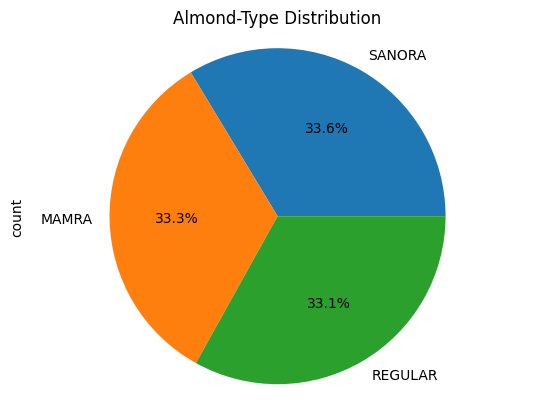

In [12]:
df['Type'].value_counts().plot.pie(autopct='%1.1f%%')
plt.axis('equal')
plt.title('Almond-Type Distribution')
plt.show()

Display descriptive statistics

In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Length (major axis),1946.0,290.609274,62.719433,151.335266,245.966293,279.879883,330.508575,515.352478
Width (minor axis),1861.0,171.025915,29.916529,88.050529,149.453659,170.168365,190.640427,258.569794
Thickness (depth),1799.0,109.705378,18.940597,59.494278,97.091682,110.280136,121.392773,181.845200
Area,2803.0,26511.117374,13782.561344,6037.000000,16211.500000,23440.500000,33451.000000,89282.000000
Perimeter,2803.0,743.863770,230.632076,311.563489,571.730009,707.487369,878.896530,1864.947387
Roundness,1946.0,0.470466,0.118673,0.173748,0.384810,0.472718,0.577553,0.697293
Solidity,2803.0,0.955828,0.039596,0.718772,0.944579,0.970422,0.981484,0.992889
Compactness,2803.0,1.825233,0.794058,1.164469,1.357398,1.576412,1.965953,9.660057
Aspect Ratio,1004.0,1.753216,0.206616,1.400082,1.612490,1.705716,1.833339,2.731251
Eccentricity,1004.0,0.813114,0.041312,0.699897,0.784476,0.810120,0.838141,0.930563


Plot feature distribution histograms before handling missing values

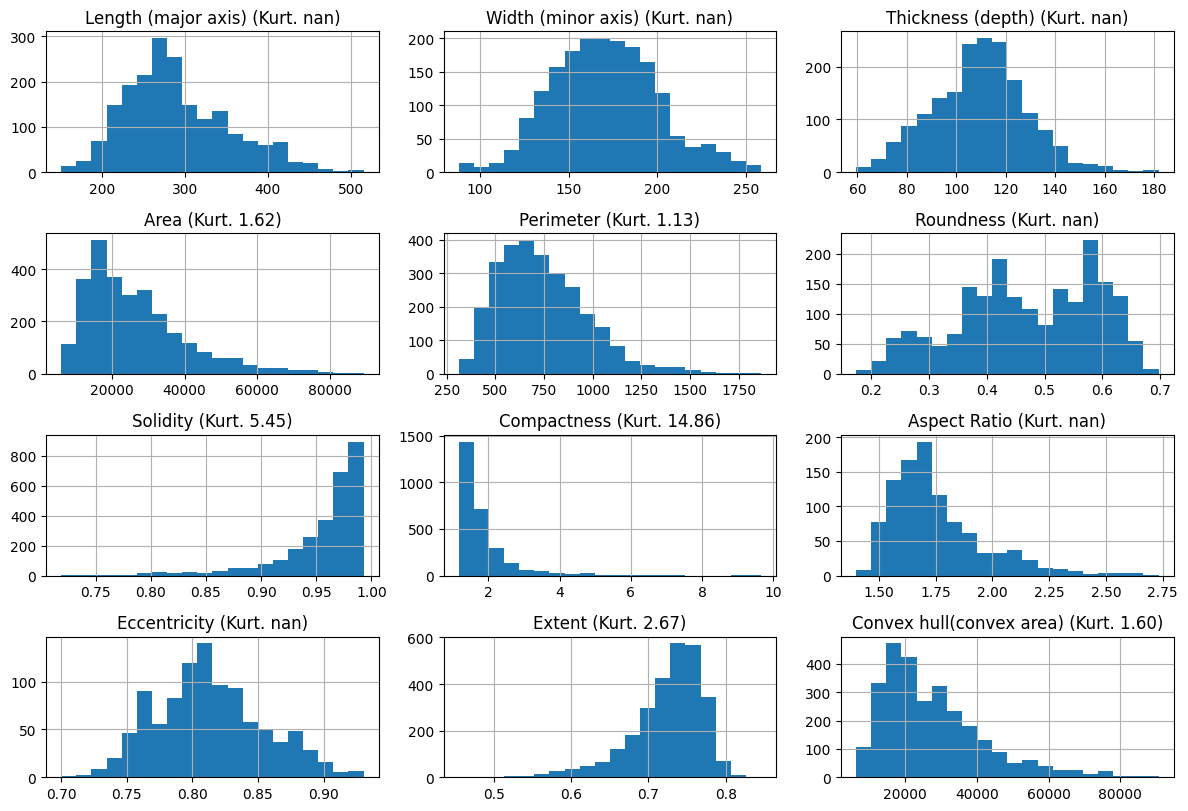

In [14]:
features = df.select_dtypes(include=['float64']).columns
num_features = len(features)

plt.figure(figsize=(12, 10))

for i, feature in enumerate(features, 1):
    plt.subplot((num_features // 3) + 1, 3, i)
    df[feature].hist(bins=20)
    kurt_value = kurtosis(df[feature], fisher=True)
    plt.title(f"{feature} (Kurt. {kurt_value:.2f})")

plt.tight_layout()
plt.show()

**NaN** kurtosis values indicate the presence of missing values which are handled below.

Plot correlation matrix of features in Almond dataset

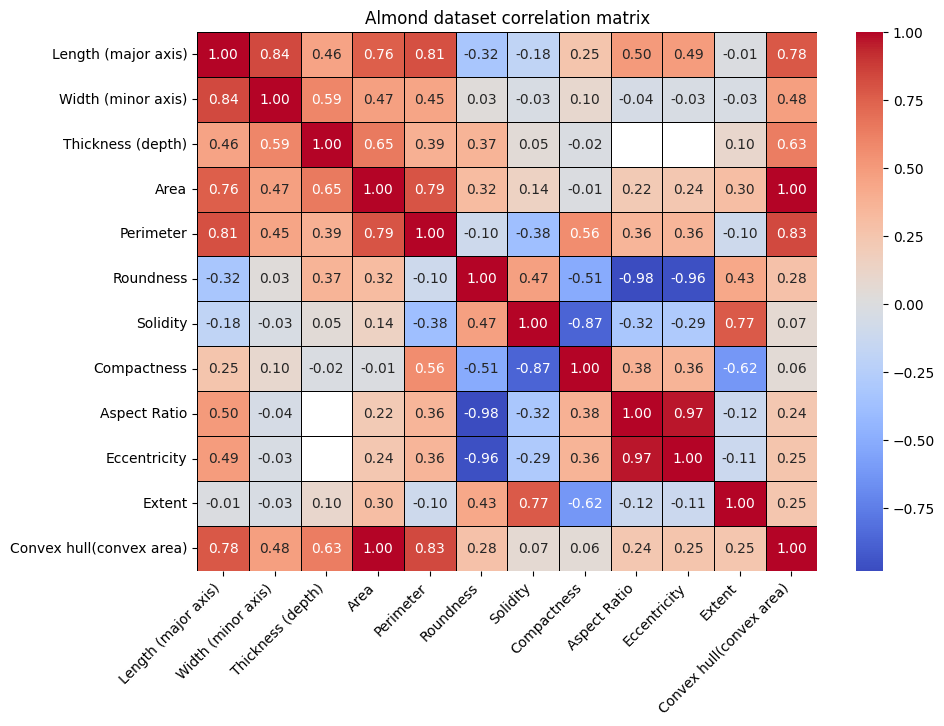

In [15]:
plt.figure(figsize=(10, 7))
numeric_df = df.select_dtypes(include=['float64'])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, linecolor='black')
plt.title("Almond dataset correlation matrix")
plt.xticks(rotation=45, ha='right')
plt.show()

Impute missing values with K-Nearest Neighbours imputer

In [16]:
cols_with_nans = [
    'Roundness', 
    'Eccentricity', 
    'Aspect Ratio', 
    'Thickness (depth)', 
    'Width (minor axis)', 
    'Length (major axis)'
]

k_imputer = KNNImputer(n_neighbors=5)
df[cols_with_nans] = k_imputer.fit_transform(df[cols_with_nans])

Get descriptive statistics after K-Nearest neighbour (KNN) imputation

In [17]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Length (major axis),2803.0,292.497698,56.550857,151.335266,255.065697,285.399719,325.160995,515.352478
Width (minor axis),2803.0,170.444245,26.923177,88.050529,151.553908,169.730862,187.856209,258.569794
Thickness (depth),2803.0,109.923305,16.650548,59.494278,100.021996,110.523758,119.677892,181.845200
Area,2803.0,26511.117374,13782.561344,6037.000000,16211.500000,23440.500000,33451.000000,89282.000000
Perimeter,2803.0,743.863770,230.632076,311.563489,571.730009,707.487369,878.896530,1864.947387
Roundness,2803.0,0.464567,0.104366,0.173748,0.394370,0.460709,0.546238,0.697293
Solidity,2803.0,0.955828,0.039596,0.718772,0.944579,0.970422,0.981484,0.992889
Compactness,2803.0,1.825233,0.794058,1.164469,1.357398,1.576412,1.965953,9.660057
Aspect Ratio,2803.0,1.753654,0.157710,1.400082,1.654173,1.724113,1.818195,2.731251
Eccentricity,2803.0,0.813289,0.031484,0.699897,0.794247,0.811407,0.831032,0.930563


Get number of missing values per column after mean-imputation

In [18]:
df.isnull().sum()

Length (major axis)         0
Width (minor axis)          0
Thickness (depth)           0
Area                        0
Perimeter                   0
Roundness                   0
Solidity                    0
Compactness                 0
Aspect Ratio                0
Eccentricity                0
Extent                      0
Convex hull(convex area)    0
Type                        0
dtype: int64

No missing values indicates k-nearest neighbour imputation successfully handled missing values.

Plot feature distributions after KNN missing-value imputation

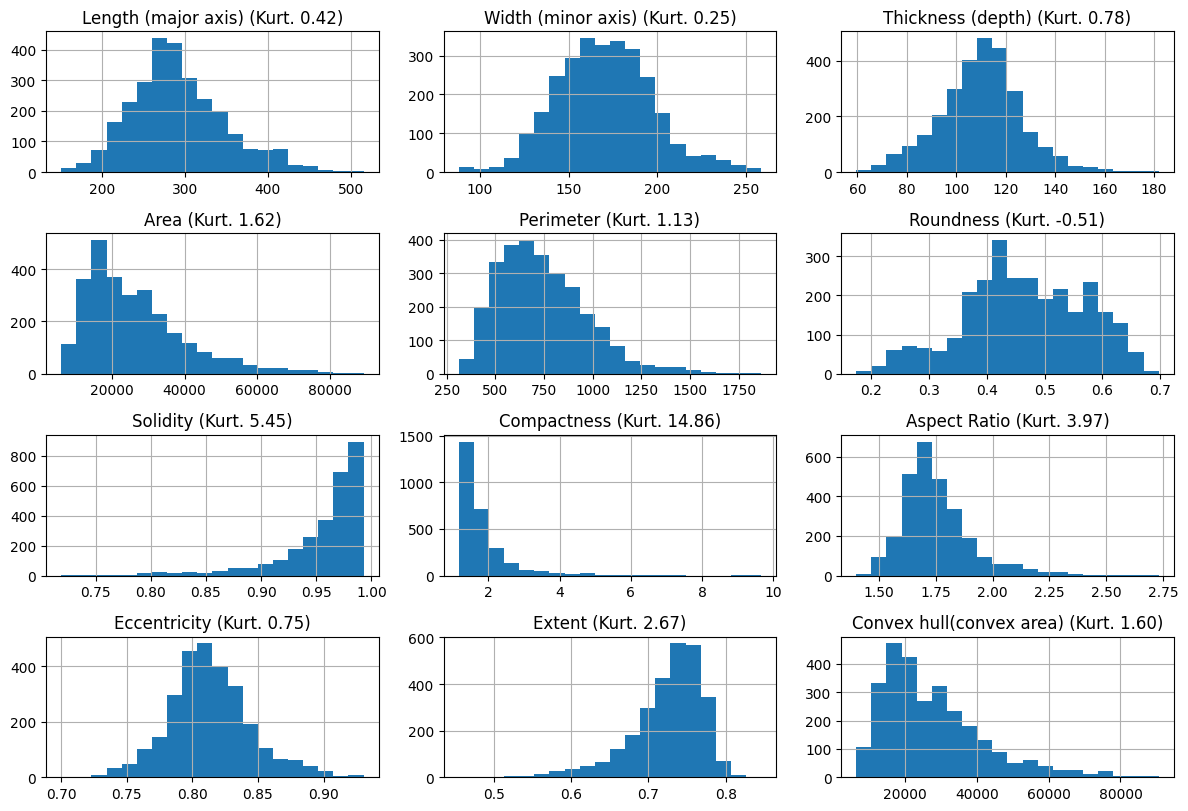

In [19]:
features = df.select_dtypes(include=['float64']).columns
num_features = len(features)

plt.figure(figsize=(12, 10))

for i, feature in enumerate(features, 1):
    plt.subplot((num_features // 3) + 1, 3, i)
    df[feature].hist(bins=20)
    kurt_value = kurtosis(df[feature], fisher=True)
    plt.title(f"{feature} (Kurt. {kurt_value:.2f})")

plt.tight_layout()
plt.show()

Features with missing values now have a kurtosis value. Kurtosis values that were present have been preserved indicating that mean imputation has preserved original distributions. New dataframe/dataset has no missing values.

Plot correlation matrix after missing-value imputation

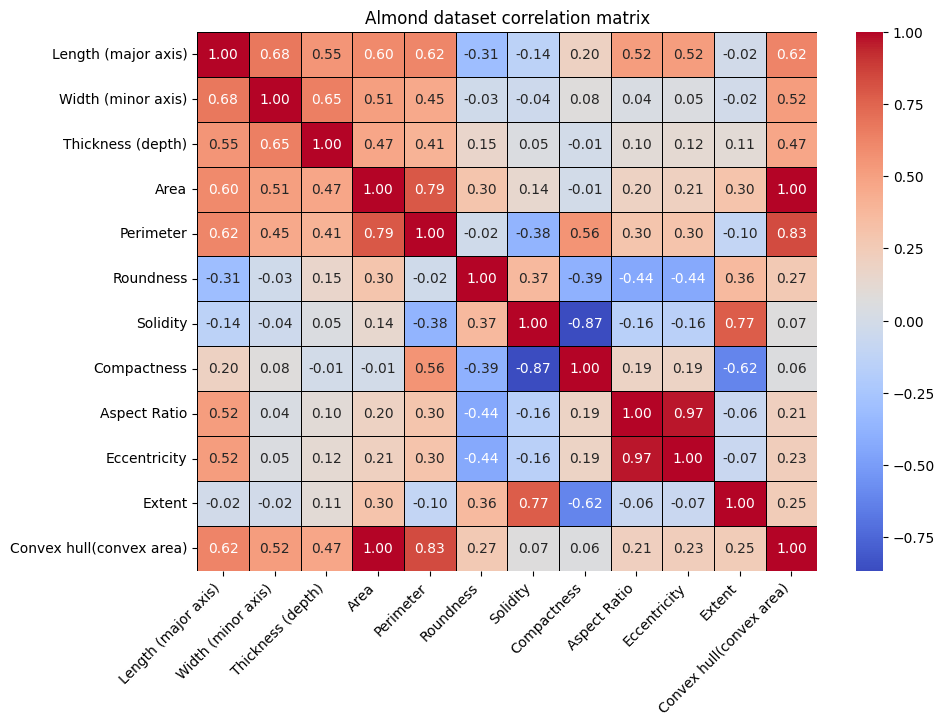

In [20]:
plt.figure(figsize=(10, 7))
numeric_df = df.select_dtypes(include=['float64'])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, linecolor='black')
plt.title("Almond dataset correlation matrix")
plt.xticks(rotation=45, ha='right')
plt.show()

Perform Z-Score standardisation

The formula for the $Z$-score is given by:

$
z \; = \; \frac{X - \mu}{\sigma}
$

Where:
- $z$ denotes the $Z$-score.
- $X$ denotes the value of the data point.
- $\mu$ denotes the mean of the feature.
- $\sigma$ denotes the standard deviation of the feature.

The $Z$-score represents the number of standard deviations a data point is away from the mean of the feature.

In [21]:
for col in df.columns:
    if col != "Type":
        mu = df[col].mean()
        sigma = df[col].std()
        df[col] = (df[col] - mu) / sigma

Class-Index Encoding for the Outcome Variable, "Type"

In [22]:
df['Type'] = df['Type'].map({ 'MAMRA': 0, 'SANORA': 1, 'REGULAR': 2 }) 

----

## Configure model (NN_u04929552)

Seed PyTorch

In [198]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

Define neural network class

In [200]:
class NN_u04929552(nn.Module):
    def __init__(self, eta, num_epochs, arch_id=0):
        super(NN_u04929552, self).__init__()
        getattr(self, f"init_arch_{arch_id}")()
        self.init_weights_biases()
        self.eta = eta
        self.num_epochs = num_epochs
        self.criterion = nn.CrossEntropyLoss()
        self.optimiser = HybridOptimiser(self.parameters(), lr=self.eta)
        self.scheduler = CosineAnnealingWarmRestarts(self.optimiser, T_0=10, T_mult=2)
        self.train_losses, self.val_losses = [], []

    def init_arch_0(self):
        self.arch = nn.Sequential(
            nn.Linear(10, 20), nn.Sigmoid(),
            nn.Linear(20, 29), nn.Sigmoid(),
            nn.Linear(29, 19), nn.Sigmoid(),
            nn.Linear(19, 13), nn.Sigmoid(),
            nn.Linear(13, 3)
        )

    def init_weights_biases(self):
        torch.manual_seed(42)
        for layer in self.arch:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                layer.bias.data.fill_(0.01)

    def forward(self, x):
        return self.arch(x)

    def train(self, train_loader, val_loader, silent=False):
        for epoch in range(self.num_epochs):
            correct_train = 0
            total_train = 0
            running_train_loss = 0

            for inputs, labels in train_loader:
                outputs = self.forward(inputs)
                loss = self.criterion(outputs, labels)
                self.optimiser.zero_grad()
                loss.backward()
                self.optimiser.step()
                _, predicted = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()
                running_train_loss += loss.item()

            avg_train_loss = running_train_loss / len(train_loader)
            train_accuracy = correct_train / total_train

            correct_val = 0
            total_val = 0
            running_val_loss = 0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    outputs = self.forward(inputs)
                    loss = self.criterion(outputs, labels)
                    _, predicted = torch.max(outputs.data, 1)
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()
                    running_val_loss += loss.item()

            avg_val_loss = running_val_loss / len(val_loader)
            val_accuracy = correct_val / total_val

            self.train_losses.append(avg_train_loss)
            self.val_losses.append(avg_val_loss)
            self.scheduler.step(epoch + 1)
            current_lr = self.scheduler.get_last_lr()[0]

            if not silent:
                if epoch % 50 == 0:
                    print(f'Epoch [{epoch+1}/{self.num_epochs}], '
                          f'Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, '
                          f'Train Accuracy: {round(train_accuracy,3)}, Val Accuracy: {round(val_accuracy,2)}, '
                          f'LR: {current_lr:.6f}')

        if not silent:
            self.plot_error()

    def test(self, data_loader):
        correct_test = 0
        total_test = 0
        running_test_loss = 0
    
        with torch.no_grad():
            for inputs, labels in data_loader:
                outputs = self.forward(inputs)
                loss = self.criterion(outputs, labels)
                running_test_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
    
        accuracy = round(correct_test / total_test, 3)
        loss = round(running_test_loss / total_test, 3)
        print(f"  >>> Test accuracy: {accuracy} - Test loss: {loss}")
        return (accuracy, loss)

    def plot_error(self):
        epochs = range(1, len(self.train_losses) + 1)
        plt.plot(epochs, self.train_losses, label='Training Loss', color='blue', linestyle='--')
        plt.plot(epochs, self.val_losses, label='Validation Loss', color='green')
        plt.xlabel('Number of Epochs')
        plt.ylabel('Error (Loss)')
        plt.title('Training and Validation Error')
        plt.legend()
        plt.show()


Define HybridOptimiser class

In [201]:
class HybridOptimiser(Optimizer):
    def __init__(self, 
                 params, 
                 lr=1e-3, 
                 eta_plus=1.2, 
                 eta_minus=0.5, 
                 delta_max=50.0, 
                 delta_min=1e-6,
                 betas=(0.9, 0.999), 
                 eps=1e-8):
        
        defaults = dict(lr=lr, 
                        eta_plus=eta_plus, 
                        eta_minus=eta_minus, 
                        delta_max=delta_max,
                        delta_min=delta_min, 
                        betas=betas, 
                        eps=eps)
        
        super(HybridOptimiser, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()
        for group in self.param_groups:
            lr = group['lr']
            eta_plus = group['eta_plus']
            eta_minus = group['eta_minus']
            delta_max = group['delta_max']
            delta_min = group['delta_min']
            betas = group['betas']
            eps = group['eps']

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('HybridOptimiser does not support sparse gradients')

                state = self.state[p]
                if len(state) == 0:
                    # For RProp
                    state['step_size'] = torch.full_like(p.data, lr)
                    state['prev_grad'] = torch.zeros_like(p.data)
                    # For Adam
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)

                # RProp Update
                prev_grad = state['prev_grad']
                step_size = state['step_size']
                sign = grad * prev_grad
                increase = (sign > 0).float()
                decrease = (sign < 0).float()
                same = (sign == 0).float()
                step_size = step_size * increase * eta_plus + step_size * decrease * eta_minus + step_size * same
                step_size = torch.clamp(step_size, delta_min, delta_max)
                grad_rprop = grad.clone()
                grad_rprop[sign < 0] = 0
                delta_rprop = -step_size * grad_rprop.sign()
                state['prev_grad'] = grad.clone()
                state['step_size'] = step_size

                # Adam Update
                exp_avg = state['exp_avg']
                exp_avg_sq = state['exp_avg_sq']
                beta1, beta2 = betas
                state['step'] += 1
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                denom = (exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(eps)
                step_size_adam = lr / bias_correction1
                delta_adam = -step_size_adam * exp_avg / denom
                delta = (delta_rprop + delta_adam) / 2
                p.data.add_(delta)

        return loss

Define utility class

In [31]:
class NN_Util():
    @staticmethod
    def get_tensor(df, dtype):
        return torch.tensor(df.values, dtype=dtype)

    @staticmethod
    def get_tensor_dataset(X_tensor, y_tensor):
        return TensorDataset(X_tensor, y_tensor)

    def get_dataloader(train_dataset, batch_size=64):
        return DataLoader(dataset=train_dataset, 
                          batch_size=batch_size)

    @staticmethod
    def plot_grid_search_results(results, epoch_lst, eta_lst):
        df_results = pd.DataFrame(results)
        pivot_table = df_results.pivot(index='eta', columns='num_epochs', values='mean')
        pivot_table = pivot_table.reindex(index=eta_lst, columns=epoch_lst)
        plt.figure(figsize=(10, 6))
        sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap='coolwarm')
        plt.xlabel('num_epochs')
        plt.ylabel('eta')
        plt.title('Validation Accuracy for Different Learning Rates and Epochs')
        plt.show()

    @staticmethod
    def create_training_df(df, dfs, indices):
        return pd.concat([df.iloc[indices], dfs], axis=0, ignore_index=True)

    @staticmethod
    def grid_search(params, X, y, X_synthetic, y_synthetic):
        KFCV_results_lst = []
        X_KFCV = X.drop(['Aspect Ratio', 'Eccentricity'], axis=1)
        X_synthetic = X_synthetic.drop(['Aspect Ratio', 'Eccentricity'], axis=1)

        for p_id, param in enumerate(params):
            sample_results = {
                "eta": (eta := param['eta']), 
                "num_epochs": (num_epochs := param['num_epochs']), 
                "sample_0": None, 
                "sample_1": None, 
                "sample_2": None, 
                "mean": None, 
                "std": None
            }
    
            sample_accuracies = [] # for mean and std calculations
            
            for sample_id, (train_indices, val_indices) in enumerate(kf.split(df)):

                print(f"Starting test of row ({p_id+1}/{len(params)}) - sample ({sample_id+1}/3)")

                X_train_KFCV = pd.concat([X_KFCV.iloc[train_indices], X_synthetic], axis=0, ignore_index=True)
                X_val_KFCV = X_KFCV.iloc[val_indices]

                y_train_KFCV = pd.concat([y.iloc[train_indices], y_synthetic], axis=0, ignore_index=True)
                y_val_KFCV = y.iloc[val_indices]
    
                X_train_KFCV_tensor = NN_Util.get_tensor(X_train_KFCV, dtype=torch.float32)
                X_val_KFCV_tensor = NN_Util.get_tensor(X_val_KFCV, dtype=torch.float32)

                y_train_KFCV_tensor = NN_Util.get_tensor(y_train_KFCV, dtype=torch.long)
                y_val_KFCV_tensor = NN_Util.get_tensor(y_val_KFCV, dtype=torch.long)
    
                train_dataset = NN_Util.get_tensor_dataset(X_train_KFCV_tensor, y_train_KFCV_tensor)
                val_dataset = NN_Util.get_tensor_dataset(X_val_KFCV_tensor, y_val_KFCV_tensor)
    
                train_loader = NN_Util.get_dataloader(train_dataset)
                val_loader = NN_Util.get_dataloader(val_dataset)
                
                model = NN_u04929552(eta=eta, num_epochs=num_epochs)
                model.train(train_loader, val_loader, silent=True)
            
                val_accuracy = model.test(val_loader)
                
                sample_results[f"sample_{sample_id}"] = val_accuracy
                sample_accuracies.append(val_accuracy)
    
            sample_results["mean"] = np.mean(sample_accuracies)
            sample_results["std"] = np.std(sample_accuracies)
            
            KFCV_results_lst.append(sample_results)
        
        return KFCV_results_lst

Separate Almond features from labels in original Almond.csv

In [23]:
X = df.iloc[:, :-1]
y = df['Type']

Separate the Almond dataset into train, validation and test (80%-10%-10%)

In [24]:
from sklearn.model_selection import train_test_split

X_train_real, X_rem, y_train_real, y_rem = train_test_split(X, y, test_size=(0.1+0.1), random_state=711)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=711)

Load synthetic data

In [25]:
dfs = pd.read_csv('data/AlmondSynthetic20000.csv')

Get number of rows in synthetic dataset

In [26]:
dfs.shape[0]

20000

Separate Almond features from labels in synthetic dataset

In [27]:
X_synthetic = dfs.iloc[:, :-1]
y_synthetic = dfs['Type']

Vertically concatenate initial training data with synthetic data to form larger training set

In [28]:
X_train = pd.concat([X_train_real, X_synthetic], axis=0, ignore_index=True)
y_train = pd.concat([y_train_real, y_synthetic], axis=0, ignore_index=True)

Remove features with majority of rows containing missing values

In [29]:
X_train = X_train.drop(['Aspect Ratio', 'Eccentricity'], axis=1)
X_val = X_val.drop(['Aspect Ratio', 'Eccentricity'], axis=1)
X_test = X_test.drop(['Aspect Ratio', 'Eccentricity'], axis=1)

Convert the features (X) to PyTorch tensors

In [32]:
X_train_tensor = NN_Util.get_tensor(X_train, torch.float32)
X_val_tensor = NN_Util.get_tensor(X_val, torch.float32)
X_test_tensor = NN_Util.get_tensor(X_test, torch.float32)

Convert the labels (y) to PyTorch tensors

In [33]:
y_train_tensor = NN_Util.get_tensor(y_train, torch.long)
y_val_tensor = NN_Util.get_tensor(y_val, torch.long)
y_test_tensor = NN_Util.get_tensor(y_test, torch.long)

Create Tensor Dataset for training, validation and test data

In [34]:
train_dataset = NN_Util.get_tensor_dataset(X_train_tensor, y_train_tensor)
val_dataset = NN_Util.get_tensor_dataset(X_val_tensor, y_val_tensor)
test_dataset = NN_Util.get_tensor_dataset(X_test_tensor, y_test_tensor)

Create DataLoaders for training, validation, and testing

In [35]:
train_loader = NN_Util.get_dataloader(train_dataset)
val_loader = NN_Util.get_dataloader(val_dataset)
test_loader = NN_Util.get_dataloader(test_dataset)

## K-Folds (K=3) Cross Validation Grid Search

Create grid search configurations

In [34]:
grid_search_params = []
epoch_lst = [450 + ep * 50 for ep in range(7)]
eta_lst = [0.004 + e * 0.001 for e in range(7)]

for ep in range(7):
    for e in range(7):
        grid_search_params.append({
            'eta': eta_lst[e],
            'num_epochs': epoch_lst[ep]
        })

Setup grid search results dataframe

In [35]:
KFCV_results = pd.DataFrame(columns=[
    "eta", "num_epochs", "sample_0", 
    "sample_1", "sample_2", "mean", "std"
])

Perform grid-search

In [36]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=3, shuffle=True)

In [37]:
grid_search_results = NN_Util.grid_search(grid_search_params, X, y, X_synthetic, y_synthetic)

Starting test of row (1/49) - sample (1/3)
Starting test of row (1/49) - sample (2/3)
Starting test of row (1/49) - sample (3/3)
Starting test of row (2/49) - sample (1/3)
Starting test of row (2/49) - sample (2/3)
Starting test of row (2/49) - sample (3/3)
Starting test of row (3/49) - sample (1/3)
Starting test of row (3/49) - sample (2/3)
Starting test of row (3/49) - sample (3/3)
Starting test of row (4/49) - sample (1/3)
Starting test of row (4/49) - sample (2/3)
Starting test of row (4/49) - sample (3/3)
Starting test of row (5/49) - sample (1/3)
Starting test of row (5/49) - sample (2/3)
Starting test of row (5/49) - sample (3/3)
Starting test of row (6/49) - sample (1/3)
Starting test of row (6/49) - sample (2/3)
Starting test of row (6/49) - sample (3/3)
Starting test of row (7/49) - sample (1/3)
Starting test of row (7/49) - sample (2/3)
Starting test of row (7/49) - sample (3/3)
Starting test of row (8/49) - sample (1/3)
Starting test of row (8/49) - sample (2/3)
Starting te

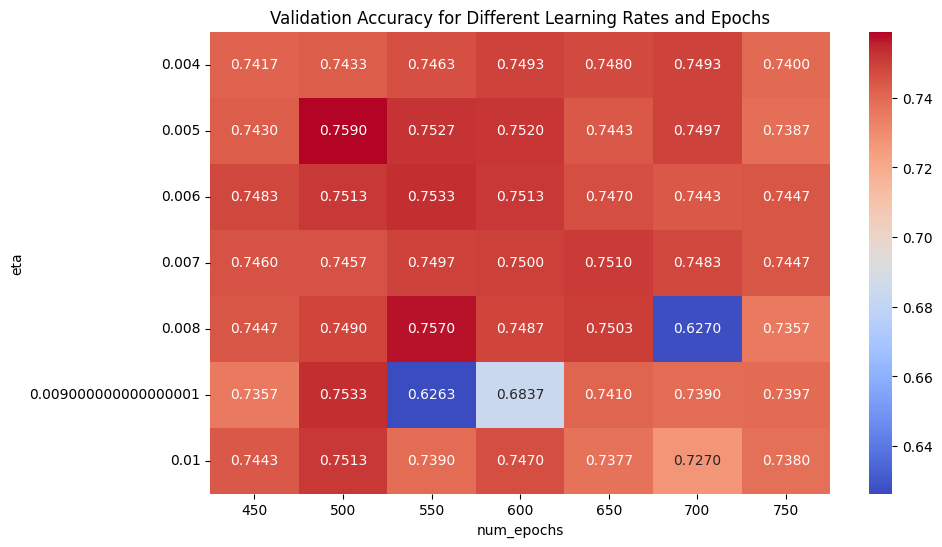

In [38]:
NN_Util.plot_grid_search_results(
    grid_search_results,
    epoch_lst,
    eta_lst
)

### Collect results from best configuration

In [214]:
(model := NN_u04929552(eta=0.007, num_epochs=600))

NN_u04929552(
  (arch): Sequential(
    (0): Linear(in_features=10, out_features=20, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=20, out_features=29, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=29, out_features=19, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=19, out_features=13, bias=True)
    (7): Sigmoid()
    (8): Linear(in_features=13, out_features=3, bias=True)
  )
  (criterion): CrossEntropyLoss()
)

Epoch [1/600], Train Loss: 0.9473, Val Loss: 0.7919, Train Accuracy: 0.532, Val Accuracy: 0.62, LR: 0.006829
Epoch [51/600], Train Loss: 0.6482, Val Loss: 0.6126, Train Accuracy: 0.697, Val Accuracy: 0.71, LR: 0.003225
Epoch [101/600], Train Loss: 0.6291, Val Loss: 0.5902, Train Accuracy: 0.707, Val Accuracy: 0.73, LR: 0.004711
Epoch [151/600], Train Loss: 0.6251, Val Loss: 0.5800, Train Accuracy: 0.71, Val Accuracy: 0.74, LR: 0.006999
Epoch [201/600], Train Loss: 0.6110, Val Loss: 0.5672, Train Accuracy: 0.719, Val Accuracy: 0.74, LR: 0.005387
Epoch [251/600], Train Loss: 0.5993, Val Loss: 0.5628, Train Accuracy: 0.725, Val Accuracy: 0.74, LR: 0.002097
Epoch [301/600], Train Loss: 0.5936, Val Loss: 0.5541, Train Accuracy: 0.726, Val Accuracy: 0.75, LR: 0.000055
Epoch [351/600], Train Loss: 0.5968, Val Loss: 0.5555, Train Accuracy: 0.724, Val Accuracy: 0.76, LR: 0.006720
Epoch [401/600], Train Loss: 0.5880, Val Loss: 0.5530, Train Accuracy: 0.728, Val Accuracy: 0.75, LR: 0.005694
Epoch

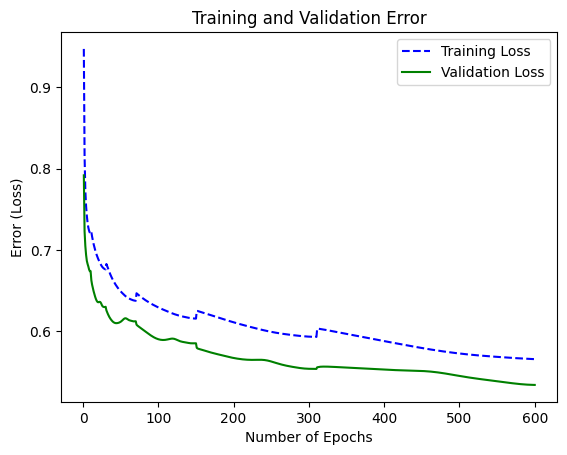

In [215]:
model.train(train_loader, val_loader)

In [216]:
model.test(test_loader)

  >>> Test accuracy: 0.822 - Test loss: 0.49


(0.822, 0.49)

# Statistical significance tests

In [36]:
num_samples = 10
stat_seeds = [42, 43, 44, 45, 46, 47, 48, 49, 50, 51] # different seed for each sample otherwise sample results repeat

In [37]:
class NN_stat(nn.Module):

    def custom_seed(self, seed):
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.use_deterministic_algorithms(True)
        
    def __init__(self, 
                 seed, 
                 eta, 
                 num_epochs, 
                 arch_id=0, 
                 weight_strat=0, 
                 lrs=2, 
                 dropout=False, 
                 optimizers=['rprop', 'adam'], 
                 optim_test=False,
                 activation=0,
                 ta=0):
        
        super(NN_stat, self).__init__()
        self.custom_seed(seed)
        self.dropout = dropout
        getattr(self, f"init_arch_{arch_id}")(dropout, activation)
        self.init_weights_biases(weight_strat, seed)
        self.eta = eta
        self.num_epochs = num_epochs
        self.criterion = nn.CrossEntropyLoss()

        if optim_test:
            self.optimiser = HybridOptimiser(self.parameters(), lr=self.eta, optimizers=optimizers)
        else:
            if ta == 0: self.optimiser = torch.optim.Adam(self.parameters(), lr=self.eta)
            if ta == 1: self.optimiser = torch.optim.Rprop(self.parameters(), lr=self.eta)
            if ta == 2: self.optimiser = torch.optim.RMSprop(self.parameters(), lr=self.eta)
        self.scheduler = None # when lrs == 0
        if lrs == 1:
            self.scheduler = torch.optim.lr_scheduler.ExponentialLR(self.optimiser, gamma=0.9)
        elif lrs == 2:
            self.scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(self.optimiser, T_0=10, T_mult=2)
        self.train_losses, self.val_losses = [], []
        self.train_accuracies, self.val_accuracies = [], []

    def init_arch_0(self, dropout, activation):

        if dropout:
            self.arch = nn.Sequential(
                nn.Linear(10, 20),
                nn.Sigmoid(),
                nn.Dropout(0.5),
                nn.Linear(20, 29),
                nn.Sigmoid(),
                nn.Dropout(0.5),
                nn.Linear(29, 19),
                nn.Sigmoid(),
                nn.Dropout(0.5),
                nn.Linear(19, 13),
                nn.Sigmoid(),
                nn.Linear(13, 3),
            )

        else:
            if activation == 0:
                self.arch = nn.Sequential(
                    nn.Linear(10, 20),
                    nn.Sigmoid(),
                    nn.Linear(20, 29),
                    nn.Sigmoid(),
                    nn.Linear(29, 19),
                    nn.Sigmoid(),
                    nn.Linear(19, 13),
                    nn.Sigmoid(),
                    nn.Linear(13, 3),
                )
                
            elif activation == 1:
                self.arch = nn.Sequential(
                    nn.Linear(10, 20),
                    nn.Tanh(),
                    nn.Linear(20, 29),
                    nn.Tanh(),
                    nn.Linear(29, 19),
                    nn.Tanh(),
                    nn.Linear(19, 13),
                    nn.Tanh(), 
                    nn.Linear(13, 3),
                )

    def init_arch_1(self, dropout):
        self.arch = nn.Sequential(
            nn.Linear(10, 84),
            nn.Sigmoid(),
            nn.Linear(84, 122),
            nn.Sigmoid(),
            nn.Linear(122, 80),
            nn.Sigmoid(),
            nn.Linear(80, 47),
            nn.Sigmoid(),
            nn.Linear(47, 3),
        )

    def init_weights_biases(self, weight_strat, seed):
        torch.manual_seed(seed)
        for layer in self.arch:
            if isinstance(layer, nn.Linear):
                if weight_strat == 0:
                    nn.init.xavier_uniform_(layer.weight)
                elif weight_strat == 1:
                    nn.init.kaiming_uniform_(layer.weight)
                layer.bias.data.fill_(0.01)

    def forward(self, x):
        return self.arch(x)

    def train(self, train_loader, val_loader, silent=False):
        for epoch in range(self.num_epochs):
            correct_train = 0
            total_train = 0
            running_train_loss = 0

            for inputs, labels in train_loader:
                outputs = self.forward(inputs)
                loss = self.criterion(outputs, labels)
                self.optimiser.zero_grad()
                loss.backward()
                self.optimiser.step()
                _, predicted = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()
                running_train_loss += loss.item()

            avg_train_loss = running_train_loss / len(train_loader)
            train_accuracy = correct_train / total_train

            correct_val = 0
            total_val = 0
            running_val_loss = 0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    outputs = self.forward(inputs)
                    loss = self.criterion(outputs, labels)
                    _, predicted = torch.max(outputs.data, 1)
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()
                    running_val_loss += loss.item()

            avg_val_loss = running_val_loss / len(val_loader)
            val_accuracy = correct_val / total_val

            self.val_accuracies.append(val_accuracy)

            self.train_losses.append(avg_train_loss)
            self.val_losses.append(avg_val_loss)

            if self.scheduler is not None:
                if isinstance(
                    self.scheduler, torch.optim.lr_scheduler.CosineAnnealingWarmRestarts
                ):
                    self.scheduler.step(epoch)
                else:
                    self.scheduler.step()
            current_lr = self.optimiser.param_groups[0]['lr']

            if not silent:
                if epoch % 50 == 0:
                    print(
                        f'Epoch [{epoch+1}/{self.num_epochs}], '
                        f'Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, '
                        f'Train Accuracy: {round(train_accuracy,3)}, Val Accuracy: {round(val_accuracy,3)}, '
                        f'LR: {current_lr:.6f}'
                    )

        return (self.val_accuracies, self.val_losses)


    def test(self, data_loader):
        correct_test = 0
        total_test = 0
        running_test_loss = 0
    
        with torch.no_grad():
            for inputs, labels in data_loader:
                outputs = self.forward(inputs)
                loss = self.criterion(outputs, labels)
                running_test_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
    
        accuracy = round(correct_test / total_test, 3)
        loss = round(running_test_loss / total_test, 3)
        print(f"  >>> Test accuracy: {accuracy} - Test loss: {loss}")
        return (accuracy, loss)


    def plot_error(self):
        epochs = range(1, len(self.train_losses) + 1)
        plt.plot(
            epochs,
            self.train_losses,
            label='Training Loss',
            color='blue',
            linestyle='--',
        )
        plt.plot(epochs, self.val_losses, label='Validation Loss', color='green')
        plt.xlabel('Number of Epochs')
        plt.ylabel('Error (Loss)')
        plt.title('Training and Validation Error')
        plt.legend()
        plt.show()


Define custom HybridOptimiser for significance testing 

In [38]:
class HybridOptimiser(Optimizer):
    def __init__(self, 
                 params, 
                 optimizers=['rprop', 'adam'],
                 lr=1e-3, 
                 eta_plus=1.2, 
                 eta_minus=0.5, 
                 delta_max=50.0, 
                 delta_min=1e-6,
                 betas=(0.9, 0.999), 
                 alpha=0.99,
                 eps=1e-8):
        
        defaults = dict(lr=lr, 
                        eta_plus=eta_plus, 
                        eta_minus=eta_minus, 
                        delta_max=delta_max,
                        delta_min=delta_min, 
                        betas=betas, 
                        alpha=alpha,
                        eps=eps,
                        optimizers=optimizers)
        
        super(HybridOptimiser, self).__init__(params, defaults)
        print(f"Selected optimizers: {optimizers}")

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()
        for group in self.param_groups:
            lr = group['lr']
            eta_plus = group['eta_plus']
            eta_minus = group['eta_minus']
            delta_max = group['delta_max']
            delta_min = group['delta_min']
            betas = group['betas']
            alpha = group['alpha']
            eps = group['eps']
            optimizers = group['optimizers']

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('HybridOptimiser does not support sparse gradients')

                state = self.state[p]
                if len(state) == 0:
                    if 'rprop' in optimizers:
                        # Initialize RProp state
                        state['step_size'] = torch.full_like(p.data, lr)
                        state['prev_grad'] = torch.zeros_like(p.data)
                    if 'adam' in optimizers:
                        state['step'] = 0
                        state['exp_avg'] = torch.zeros_like(p.data)
                        state['exp_avg_sq'] = torch.zeros_like(p.data)
                    if 'rmsprop' in optimizers:
                        state['square_avg'] = torch.zeros_like(p.data)

                deltas = []

                if 'rprop' in optimizers:
                    # RProp Update
                    prev_grad = state['prev_grad']
                    step_size = state['step_size']
                    sign = grad * prev_grad
                    increase = (sign > 0).float()
                    decrease = (sign < 0).float()
                    same = (sign == 0).float()
                    step_size = step_size * increase * eta_plus + step_size * decrease * eta_minus + step_size * same
                    step_size = torch.clamp(step_size, delta_min, delta_max)
                    grad_rprop = grad.clone()
                    grad_rprop[sign < 0] = 0
                    delta_rprop = -step_size * grad_rprop.sign()
                    state['prev_grad'] = grad.clone()
                    state['step_size'] = step_size
                    deltas.append(delta_rprop)

                if 'adam' in optimizers:
                    # Adam Update
                    exp_avg = state['exp_avg']
                    exp_avg_sq = state['exp_avg_sq']
                    beta1, beta2 = betas
                    state['step'] += 1
                    exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                    exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
                    bias_correction1 = 1 - beta1 ** state['step']
                    bias_correction2 = 1 - beta2 ** state['step']
                    denom = (exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(eps)
                    step_size_adam = lr / bias_correction1
                    delta_adam = -step_size_adam * exp_avg / denom
                    deltas.append(delta_adam)

                if 'rmsprop' in optimizers:
                    # RMSprop Update
                    square_avg = state['square_avg']
                    alpha_rms = alpha
                    square_avg.mul_(alpha_rms).addcmul_(grad, grad, value=1 - alpha_rms)
                    avg = square_avg.sqrt().add_(eps)
                    delta_rmsprop = -lr * grad / avg
                    deltas.append(delta_rmsprop)

                if deltas:
                    delta = sum(deltas) / len(deltas)
                    p.data.add_(delta)
                else:
                    raise ValueError("No valid optimizers specified in 'optimizers'")

        return loss


1. Perform paired t-test on two architecture selections

In [145]:
accuracy_results = []
loss_results = []
for arch_id in range((num_vars := 2)):
    sample_accuracies = []
    sample_losses = []
    for sid in range(num_samples):
        print(f"Architecture Test ==============> Architecture: {arch_id+1}/{num_vars} - Sample: {sid+1}/{num_samples}")
        model = NN_stat(stat_seeds[sid], eta=0.007, num_epochs=630, arch_id=arch_id)
        model.train(train_loader, val_loader, silent=True)
        sample_accuracy, sample_loss = model.test(test_loader)
        sample_accuracies.append(sample_accuracy)
        sample_losses.append(sample_loss)
        
    accuracy_results.append(sample_accuracies)
    loss_results.append(sample_losses)

print(f"Architecture 1 of 2 accuracy results: {accuracy_results[0]}")
print(f"Architecture 2 of 2 accuracy results: {accuracy_results[1]}")

print(f"Architecture 1 of 2 loss results: {loss_results[0]}")
print(f"Architecture 2 of 2 loss results: {loss_results[1]}")

print(paired_t_test(accuracy_results))
print(paired_t_test(loss_results))

Architecture Test ==============> Architecture: 1/2 - Sample: 1/10
  >>> Test accuracy: 0.779 - Test loss: 0.726
Architecture Test ==============> Architecture: 1/2 - Sample: 2/10
  >>> Test accuracy: 0.722 - Test loss: 0.673
Architecture Test ==============> Architecture: 1/2 - Sample: 3/10
  >>> Test accuracy: 0.797 - Test loss: 0.541
Architecture Test ==============> Architecture: 1/2 - Sample: 4/10
  >>> Test accuracy: 0.744 - Test loss: 0.623
Architecture Test ==============> Architecture: 1/2 - Sample: 5/10
  >>> Test accuracy: 0.765 - Test loss: 0.638
Architecture Test ==============> Architecture: 1/2 - Sample: 6/10
  >>> Test accuracy: 0.751 - Test loss: 0.637
Architecture Test ==============> Architecture: 1/2 - Sample: 7/10
  >>> Test accuracy: 0.758 - Test loss: 0.601
Architecture Test ==============> Architecture: 1/2 - Sample: 8/10
  >>> Test accuracy: 0.762 - Test loss: 0.614
Architecture Test ==============> Architecture: 1/2 - Sample: 9/10
  >>> Test accuracy: 0.751 - 

Compute mean and standard deviation of test results

In [6]:
tupA = calculate_stats( # Architecture 1 accuracy results: 
    [0.779, 0.722, 0.797, 0.744, 0.765, 0.751, 0.758, 0.762, 0.751, 0.74]
)

tupB = calculate_stats( # Architecture 1 loss results: 
    [0.719, 0.733, 0.762, 0.747, 0.74, 0.701, 0.754, 0.747, 0.762, 0.712]
)

tupC = calculate_stats( # Architecture 2 accuracy results: 
    [0.726, 0.673, 0.541, 0.623, 0.638, 0.637, 0.601, 0.614, 0.579, 0.645]
)

tupD = calculate_stats( # Architecture 2 loss results: 
    [3.098, 2.339, 1.784, 2.285, 2.147, 2.672, 1.833, 1.802, 2.21, 2.656]
)

print(f"Architecture 1 accuracy, mu: {tupA[0]}, sigma: {tupA[1]}")
print(f"Architecture 1 loss, mu: {tupB[0]}, sigma: {tupB[1]}")

print(f"Architecture 2 accuracy, mu: {tupC[0]}, sigma: {tupC[1]}")
print(f"Architecture 2 loss, mu: {tupD[0]}, sigma: {tupD[1]}")

Architecture 1 accuracy, mu: 0.757, sigma: 0.02
Architecture 1 loss, mu: 0.738, sigma: 0.02
Architecture 2 accuracy, mu: 0.628, sigma: 0.048
Architecture 2 loss, mu: 2.283, sigma: 0.408


2. Perform ANOVA and Tukey-HSD test of significance on learning-rate schedulers

In [151]:
accuracy_results = []
loss_results = []
for lrsid in range((num_vars := 3)):
    sample_accuracies = []
    sample_losses = []
    for sid in range(num_samples):
        print(f"Learning Rate Scheduler Test ==============> Learning Rate Scheduler: {lrsid+1}/{num_vars} - Sample: {sid+1}/{num_samples}")
        model = NN_stat(stat_seeds[sid], eta=0.007, num_epochs=630, lrs=lrsid)
        model.train(train_loader, val_loader, silent=True)
        sample_accuracy, sample_loss = model.test(test_loader)
        sample_accuracies.append(sample_accuracy)
        sample_losses.append(sample_loss)

    accuracy_results.append(sample_accuracies)
    loss_results.append(sample_losses)

# Display collected results
for i in range(len(loss_results)):
    print(f"LRS_{i} accuracy results: {accuracy_results[i]}")
    print(f"LRS_{i} loss results: {loss_results[i]}")

# Test accuracy significance tests
print(anova_test(accuracy_results))
print(tukey_post_hoc(accuracy_results))

# Test loss significance results
print(anova_test(loss_results))
print(tukey_post_hoc(loss_results))

Learning Rate Scheduler Test ==============> Learning Rate Scheduler: 1/3 - Sample: 1/10
Learning Rate Scheduler: None
  >>> Test accuracy: 0.758 - Test loss: 0.548
Learning Rate Scheduler Test ==============> Learning Rate Scheduler: 1/3 - Sample: 2/10
Learning Rate Scheduler: None
  >>> Test accuracy: 0.74 - Test loss: 0.614
Learning Rate Scheduler Test ==============> Learning Rate Scheduler: 1/3 - Sample: 3/10
Learning Rate Scheduler: None
  >>> Test accuracy: 0.769 - Test loss: 0.542
Learning Rate Scheduler Test ==============> Learning Rate Scheduler: 1/3 - Sample: 4/10
Learning Rate Scheduler: None
  >>> Test accuracy: 0.737 - Test loss: 0.601
Learning Rate Scheduler Test ==============> Learning Rate Scheduler: 1/3 - Sample: 5/10
Learning Rate Scheduler: None
  >>> Test accuracy: 0.758 - Test loss: 0.583
Learning Rate Scheduler Test ==============> Learning Rate Scheduler: 1/3 - Sample: 6/10
Learning Rate Scheduler: None
  >>> Test accuracy: 0.758 - Test loss: 0.577
Learning Ra

Compute mean and standard deviation of test results

In [7]:
tupA = calculate_stats( # No LRS accuracy results: 
    [0.758, 0.74, 0.769, 0.737, 0.758, 0.758, 0.733, 0.754, 0.737, 0.737]
)

tupB = calculate_stats( # No LRS loss results: 
    [0.548, 0.614, 0.542, 0.601, 0.583, 0.577, 0.611, 0.625, 0.619, 0.619]
)

tupC = calculate_stats( # Exponential accuracy results: 
    [0.733, 0.73, 0.747, 0.747, 0.769, 0.747, 0.751, 0.747, 0.751, 0.758]
)

tupD = calculate_stats( # Exponential loss results: 
    [0.627, 0.598, 0.603, 0.602, 0.596, 0.591, 0.597, 0.584, 0.599, 0.597]
)

tupE = calculate_stats( # CAWR accuracy results: 
    [0.779, 0.722, 0.797, 0.744, 0.765, 0.751, 0.758, 0.762, 0.751, 0.74]
)

tupF = calculate_stats( # CAWR loss results: 
    [0.726, 0.673, 0.541, 0.623, 0.638, 0.637, 0.601, 0.614, 0.579, 0.645]
)

print(f"No LRS Accuracy, mu: {tupA[0]}, sigma: {tupA[1]}")
print(f"No LRS Loss, mu: {tupB[0]}, sigma: {tupB[1]}")

print(f"Exponential LRS Accuracy, mu: {tupC[0]}, sigma: {tupC[1]}")
print(f"Exponential LRS Loss, mu: {tupD[0]}, sigma: {tupD[1]}")

print(f"CAWR Accuracy, mu: {tupE[0]}, sigma: {tupE[1]}")
print(f"CAWR Loss, mu: {tupF[0]}, sigma: {tupF[1]}")

No LRS Accuracy, mu: 0.748, sigma: 0.012
No LRS Loss, mu: 0.594, sigma: 0.029
Exponential LRS Accuracy, mu: 0.748, sigma: 0.011
Exponential LRS Loss, mu: 0.599, sigma: 0.011
CAWR Accuracy, mu: 0.757, sigma: 0.02
CAWR Loss, mu: 0.628, sigma: 0.048


3. Perform paired t-test on activation functions

In [165]:
accuracy_results = []
loss_results = []

for vid in range(2):
    sample_accuracies = []
    sample_losses = []
    for sid in range(num_samples):
        print(f"Activation Function Test ==============> Activation function: {vid+1}/2 - Sample: {sid+1}/{num_samples}")
        model = NN_stat(stat_seeds[sid], eta=0.007, num_epochs=630, activation=vid)
        model.train(train_loader, val_loader, silent=True)
        sample_accuracy, sample_loss = model.test(test_loader)
        sample_accuracies.append(sample_accuracy)
        sample_losses.append(sample_loss)
        
    accuracy_results.append(sample_accuracies)
    loss_results.append(sample_losses)

for i in range(2):
    print(f"Activation function {i} accuracy results: {accuracy_results[i]}")
    print(f"Activation function {i} loss results: {loss_results[i]}")

print(paired_t_test(accuracy_results))
print(paired_t_test(loss_results))

Activation Function Test ==============> Activation function: 1/2 - Sample: 1/10
Activation function: Sigmoid
  >>> Test accuracy: 0.779 - Test loss: 0.726
Activation Function Test ==============> Activation function: 1/2 - Sample: 2/10
Activation function: Sigmoid
  >>> Test accuracy: 0.722 - Test loss: 0.673
Activation Function Test ==============> Activation function: 1/2 - Sample: 3/10
Activation function: Sigmoid
  >>> Test accuracy: 0.797 - Test loss: 0.541
Activation Function Test ==============> Activation function: 1/2 - Sample: 4/10
Activation function: Sigmoid
  >>> Test accuracy: 0.744 - Test loss: 0.623
Activation Function Test ==============> Activation function: 1/2 - Sample: 5/10
Activation function: Sigmoid
  >>> Test accuracy: 0.765 - Test loss: 0.638
Activation Function Test ==============> Activation function: 1/2 - Sample: 6/10
Activation function: Sigmoid
  >>> Test accuracy: 0.751 - Test loss: 0.637
Activation Function Test ==============> Activation function: 1/

In [10]:
tupA = calculate_stats( # Sigmoid accuracy results: 
    [0.779, 0.722, 0.797, 0.744, 0.765, 0.751, 0.758, 0.762, 0.751, 0.74]
)

tupB = calculate_stats( # Sigmoid loss results: 
    [0.726, 0.673, 0.541, 0.623, 0.638, 0.637, 0.601, 0.614, 0.579, 0.645]
)

tupC = calculate_stats( # Hyperbolic Tangent accuracy results: 
    [0.769, 0.719, 0.754, 0.74, 0.737, 0.783, 0.751, 0.733, 0.769, 0.74]
)

tupD = calculate_stats( # Hyperbolic Tangent loss results: 
    [0.586, 0.637, 0.573, 0.579, 0.619, 0.578, 0.653, 0.632, 0.573, 0.615]
)

print(f"Sigmoid accuracy, mu: {tupA[0]}, sigma: {tupA[1]}")
print(f"Sigmoid loss, mu: {tupB[0]}, sigma: {tupB[1]}")

print(f"Hyperbolic Tangent accuracy, mu: {tupC[0]}, sigma: {tupC[1]}")
print(f"Hyperbolic Tangent loss, mu: {tupD[0]}, sigma: {tupD[1]}")

Sigmoid accuracy, mu: 0.757, sigma: 0.02
Sigmoid loss, mu: 0.628, sigma: 0.048
Hyperbolic Tangent accuracy, mu: 0.75, sigma: 0.019
Hyperbolic Tangent loss, mu: 0.605, sigma: 0.029


4. Perform paired t-test on dropout usage

In [167]:
accuracy_results = []
loss_results = []
vals = [True, False]
for vid in range(2):
    sample_accuracies = []
    sample_losses = []
    for sid in range(num_samples):
        print(f"Dropout Test ==============> Dropout? {vals[vid]} - Sample: {sid+1}/{num_samples}")
        model = NN_stat(stat_seeds[sid], eta=0.007, num_epochs=630, dropout=vals[vid])
        model.train(train_loader, val_loader, silent=True)
        sample_accuracy, sample_loss = model.test(test_loader)
        sample_accuracies.append(sample_accuracy)
        sample_losses.append(sample_loss)
        
    accuracy_results.append(sample_accuracies)
    loss_results.append(sample_losses)

for i in range(2):
    print(f"(Dropout <- {vals[i]}) accuracy results: {accuracy_results[i]}")
    print(f"(Dropout <- {vals[i]}) loss results: {loss_results[i]}")

print(paired_t_test(accuracy_results))
print(paired_t_test(loss_results))

Dropout Test ==============> Dropout? True - Sample: 1/10
  >>> Test accuracy: 0.658 - Test loss: 0.76
Dropout Test ==============> Dropout? True - Sample: 2/10
  >>> Test accuracy: 0.658 - Test loss: 0.791
Dropout Test ==============> Dropout? True - Sample: 3/10
  >>> Test accuracy: 0.644 - Test loss: 0.787
Dropout Test ==============> Dropout? True - Sample: 4/10
  >>> Test accuracy: 0.63 - Test loss: 0.771
Dropout Test ==============> Dropout? True - Sample: 5/10
  >>> Test accuracy: 0.623 - Test loss: 0.81
Dropout Test ==============> Dropout? True - Sample: 6/10
  >>> Test accuracy: 0.68 - Test loss: 0.762
Dropout Test ==============> Dropout? True - Sample: 7/10
  >>> Test accuracy: 0.63 - Test loss: 0.788
Dropout Test ==============> Dropout? True - Sample: 8/10
  >>> Test accuracy: 0.644 - Test loss: 0.758
Dropout Test ==============> Dropout? True - Sample: 9/10
  >>> Test accuracy: 0.655 - Test loss: 0.811
Dropout Test ==============> Dropout? True - Sample: 10/10
  >>> Test

Compute mean and standard deviation of results

In [239]:
tupA = calculate_stats( # (Dropout <- True) accuracy results: 
    [0.658, 0.658, 0.644, 0.63, 0.623, 0.68, 0.63, 0.644, 0.655, 0.619]
)

tupB = calculate_stats( # (Dropout <- True) loss results: 
    [0.76, 0.791, 0.787, 0.771, 0.81, 0.762, 0.788, 0.758, 0.811, 0.798]
)

tupC = calculate_stats( # (Dropout <- False) accuracy results: 
    [0.779, 0.722, 0.797, 0.744, 0.765, 0.751, 0.758, 0.762, 0.751, 0.74]
)

tupD = calculate_stats( # (Dropout <- False) loss results: 
    [0.726, 0.673, 0.541, 0.623, 0.638, 0.637, 0.601, 0.614, 0.579, 0.645]
)

print(f"Dropout True Accuracy, mu: {tupA[0]}, sigma: {tupA[1]}")
print(f"Dropout True Loss, mu: {tupB[0]}, sigma: {tupB[1]}")

print(f"Dropout False Accuracy, mu: {tupC[0]}, sigma: {tupC[1]}")
print(f"Dropout False Loss, mu: {tupD[0]}, sigma: {tupD[1]}")

Dropout True Accuracy, mu: 0.644, sigma: 0.018
Dropout True Loss, mu: 0.784, sigma: 0.019
Dropout False Accuracy, mu: 0.757, sigma: 0.02
Dropout False Loss, mu: 0.628, sigma: 0.048


5. Perform paired t-test on weight initialisation strategies

In [168]:
accuracy_results = []
loss_results = []
for vid in range(2):
    sample_accuracies = []
    sample_losses = []
    for sid in range(num_samples):
        print(f"Weight Initialisation Test ==============> Strategy: {vid+1}/2 - Sample: {sid+1}/{num_samples}")
        model = NN_stat(stat_seeds[sid], eta=0.007, num_epochs=630, weight_strat=vid)
        model.train(train_loader, val_loader, silent=True)
        sample_accuracy, sample_loss = model.test(test_loader)
        sample_accuracies.append(sample_accuracy)
        sample_losses.append(sample_loss)
        
    accuracy_results.append(sample_accuracies)
    loss_results.append(sample_losses)

for i in range(2):
    print(f"Weight strategy {i} accuracy results: {accuracy_results[i]}")
    print(f"Weight strategy {i} loss results: {loss_results[i]}")

print(paired_t_test(accuracy_results))
print(paired_t_test(loss_results))

Wight Initialisation Test ==============> Strategy: 1/2 - Sample: 1/10
Activation function: Sigmoid
  >>> Test accuracy: 0.779 - Test loss: 0.726
Wight Initialisation Test ==============> Strategy: 1/2 - Sample: 2/10
Activation function: Sigmoid
  >>> Test accuracy: 0.722 - Test loss: 0.673
Wight Initialisation Test ==============> Strategy: 1/2 - Sample: 3/10
Activation function: Sigmoid
  >>> Test accuracy: 0.797 - Test loss: 0.541
Wight Initialisation Test ==============> Strategy: 1/2 - Sample: 4/10
Activation function: Sigmoid
  >>> Test accuracy: 0.744 - Test loss: 0.623
Wight Initialisation Test ==============> Strategy: 1/2 - Sample: 5/10
Activation function: Sigmoid
  >>> Test accuracy: 0.765 - Test loss: 0.638
Wight Initialisation Test ==============> Strategy: 1/2 - Sample: 6/10
Activation function: Sigmoid
  >>> Test accuracy: 0.751 - Test loss: 0.637
Wight Initialisation Test ==============> Strategy: 1/2 - Sample: 7/10
Activation function: Sigmoid
  >>> Test accuracy: 0.7

Compute mean and standard deviation of results

In [240]:
tupA = calculate_stats( # Sigmoid accuracy results: 
    [0.779, 0.722, 0.797, 0.744, 0.765, 0.751, 0.758, 0.762, 0.751, 0.74]
)

tupB = calculate_stats( # Sigmoid loss results: 
    [0.726, 0.673, 0.541, 0.623, 0.638, 0.637, 0.601, 0.614, 0.579, 0.645]
)

tupC = calculate_stats( # Hyperbolic Tangent accuracy results: 
    [0.733, 0.779, 0.754, 0.776, 0.769, 0.801, 0.765, 0.779, 0.762, 0.762]
)

tupD = calculate_stats( # Hyperbolic Tangent loss results: 
    [0.594, 0.779, 0.698, 0.552, 0.573, 0.596, 0.568, 0.569, 0.584, 0.553]
)

print(f"Sigmoid Accuracy, mu: {tupA[0]}, sigma: {tupA[1]}")
print(f"Sigmoid Loss, mu: {tupB[0]}, sigma: {tupB[1]}")

print(f"Hyperbolic Tangent Accuracy, mu: {tupC[0]}, sigma: {tupC[1]}")
print(f"Hyperbolic Tangent Loss, mu: {tupD[0]}, sigma: {tupD[1]}")

Sigmoid Accuracy, mu: 0.757, sigma: 0.02
Sigmoid Loss, mu: 0.628, sigma: 0.048
Hyperbolic Tangent Accuracy, mu: 0.768, sigma: 0.017
Hyperbolic Tangent Loss, mu: 0.607, sigma: 0.07


6. Perform ANOVA and Tukey-HSD test of significance on number of epochs

In [170]:
accuracy_results = []
loss_results = []
vals = [300, 630, 1000]

for vid in range(3):
    sample_accuracies = []
    sample_losses = []
    for sid in range(num_samples):
        print(f"Number of Epochs Test ==============> Number of Epochs: {vals[vid]} - Sample: {sid+1}/{num_samples}")
        model = NN_stat(stat_seeds[sid], eta=0.007, num_epochs=vals[vid])
        model.train(train_loader, val_loader, silent=True)
        sample_accuracy, sample_loss = model.test(test_loader)
        sample_accuracies.append(sample_accuracy)
        sample_losses.append(sample_loss)

    accuracy_results.append(sample_accuracies)
    loss_results.append(sample_losses)

# Display collected results
for i in range(3):
    print(f"Number of Epochs {vals[i]} accuracy results: {accuracy_results[i]}")
    print(f"Number of Epochs {vals[i]} loss results: {loss_results[i]}")

# Test accuracy significance tests
print(anova_test(accuracy_results))
print(tukey_post_hoc(accuracy_results))

# Test loss significance results
print(anova_test(loss_results))
print(tukey_post_hoc(loss_results))

Number of Epochs Test ==============> Number of Epochs: 300 - Sample: 1/10
Activation function: Sigmoid
  >>> Test accuracy: 0.769 - Test loss: 0.608
Number of Epochs Test ==============> Number of Epochs: 300 - Sample: 2/10
Activation function: Sigmoid
  >>> Test accuracy: 0.769 - Test loss: 0.569
Number of Epochs Test ==============> Number of Epochs: 300 - Sample: 3/10
Activation function: Sigmoid
  >>> Test accuracy: 0.783 - Test loss: 0.542
Number of Epochs Test ==============> Number of Epochs: 300 - Sample: 4/10
Activation function: Sigmoid
  >>> Test accuracy: 0.762 - Test loss: 0.585
Number of Epochs Test ==============> Number of Epochs: 300 - Sample: 5/10
Activation function: Sigmoid
  >>> Test accuracy: 0.776 - Test loss: 0.535
Number of Epochs Test ==============> Number of Epochs: 300 - Sample: 6/10
Activation function: Sigmoid
  >>> Test accuracy: 0.783 - Test loss: 0.541
Number of Epochs Test ==============> Number of Epochs: 300 - Sample: 7/10
Activation function: Sigm

Compute mean and standard deviation of results

In [242]:
tupA = calculate_stats( # (Epochs=300) accuracy results: 
    [0.769, 0.769, 0.783, 0.762, 0.776, 0.783, 0.758, 0.79, 0.758, 0.758]
)

tupB = calculate_stats( # (Epochs=300) loss results: 
    [0.608, 0.569, 0.542, 0.585, 0.535, 0.541, 0.538, 0.525, 0.557, 0.569]
)

tupC = calculate_stats( # (Epochs=630) accuracy results: 
    [0.779, 0.722, 0.797, 0.744, 0.765, 0.751, 0.758, 0.762, 0.751, 0.74]
)

tupD = calculate_stats( # (Epochs=630) loss results: 
    [0.726, 0.673, 0.541, 0.623, 0.638, 0.637, 0.601, 0.614, 0.579, 0.645]
)

tupE = calculate_stats( # (Epochs=1000) accuracy results: 
    [0.747, 0.769, 0.776, 0.765, 0.776, 0.754, 0.733, 0.762, 0.762, 0.765]
)

tupF = calculate_stats( # (Epochs=1000) loss results: 
    [0.792, 0.631, 0.579, 0.729, 0.631, 0.65, 0.681, 0.629, 0.632, 0.612]
)

print(f"(Epochs=300) Accuracy, mu: {tupA[0]}, sigma: {tupA[1]}")
print(f"(Epochs=300) Loss, mu: {tupB[0]}, sigma: {tupB[1]}")

print(f"(Epochs=630) Accuracy, mu: {tupC[0]}, sigma: {tupC[1]}")
print(f"(Epochs=630) Loss, mu: {tupD[0]}, sigma: {tupD[1]}")

print(f"(Epochs=1000) Accuracy, mu: {tupE[0]}, sigma: {tupE[1]}")
print(f"(Epochs=1000) Loss, mu: {tupF[0]}, sigma: {tupF[1]}")

(Epochs=300) Accuracy, mu: 0.771, sigma: 0.011
(Epochs=300) Loss, mu: 0.557, sigma: 0.025
(Epochs=630) Accuracy, mu: 0.757, sigma: 0.02
(Epochs=630) Loss, mu: 0.628, sigma: 0.048
(Epochs=1000) Accuracy, mu: 0.761, sigma: 0.013
(Epochs=1000) Loss, mu: 0.657, sigma: 0.059


7. Perform ANOVA and Tukey-HSD test of significance for HybridOptimiser combinations

In [158]:
accuracy_results = []
loss_results = []
optim_lst = [['rprop', 'rmsprop'], ['adam', 'rmsprop'], ['rprop', 'adam']]

for vid in range(3):
    sample_accuracies = []
    sample_losses = []
    for sid in range(num_samples):
        print(f"Optimiser Combination Test ==============> Optimiser Combination: {optim_lst[vid]} - Sample: {sid+1}/{num_samples}")
        model = NN_stat(seed=stat_seeds[sid], eta=0.007, num_epochs=630, optimizers=optim_lst[vid], optim_test=True)
        model.train(train_loader, val_loader, silent=True)
        sample_accuracy, sample_loss = model.test(test_loader)
        sample_accuracies.append(sample_accuracy)
        sample_losses.append(sample_loss)

    accuracy_results.append(sample_accuracies)
    loss_results.append(sample_losses)

# Display collected results
for i in range(3):
    print(f"Optimiser combination {i} accuracy results: {accuracy_results[i]}")
    print(f"Optimiser combination {i} loss results: {loss_results[i]}")

# Test accuracy significance tests
print(anova_test(accuracy_results))
print(tukey_post_hoc(accuracy_results))

# Test loss significance results
print(anova_test(loss_results))
print(tukey_post_hoc(loss_results))

Optimiser Combination Test ==============> Optimiser Combination: ['rprop', 'rmsprop'] - Sample: 1/10
Selected optimizers: ['rprop', 'rmsprop']
  >>> Test accuracy: 0.804 - Test loss: 0.521
Optimiser Combination Test ==============> Optimiser Combination: ['rprop', 'rmsprop'] - Sample: 2/10
Selected optimizers: ['rprop', 'rmsprop']
  >>> Test accuracy: 0.769 - Test loss: 0.535
Optimiser Combination Test ==============> Optimiser Combination: ['rprop', 'rmsprop'] - Sample: 3/10
Selected optimizers: ['rprop', 'rmsprop']
  >>> Test accuracy: 0.79 - Test loss: 0.519
Optimiser Combination Test ==============> Optimiser Combination: ['rprop', 'rmsprop'] - Sample: 4/10
Selected optimizers: ['rprop', 'rmsprop']
  >>> Test accuracy: 0.772 - Test loss: 0.58
Optimiser Combination Test ==============> Optimiser Combination: ['rprop', 'rmsprop'] - Sample: 5/10
Selected optimizers: ['rprop', 'rmsprop']
  >>> Test accuracy: 0.772 - Test loss: 0.518
Optimiser Combination Test ==============> Optimiser

Compute mean and standard deviation for test results

In [9]:
tupA = calculate_stats( # ['rprop', 'rmsprop'] accuracy results: 
    [0.804, 0.769, 0.79, 0.772, 0.772, 0.762, 0.762, 0.794, 0.776, 0.779]
)

tupB = calculate_stats( # ['rprop', 'rmsprop'] loss results: 
    [0.521, 0.535, 0.519, 0.58, 0.518, 0.564, 0.574, 0.526, 0.564, 0.519]
)

tupC = calculate_stats( # ['adam', 'rmsprop'] accuracy results: 
    [0.754, 0.758, 0.786, 0.762, 0.758, 0.733, 0.776, 0.79, 0.772, 0.776]
)

tupD = calculate_stats( # ['adam', 'rmsprop'] loss results: 
    [0.642, 0.593, 0.663, 0.595, 0.662, 0.532, 0.579, 0.535, 0.601, 0.591]
)

tupE = calculate_stats( # ['rprop', 'adam'] accuracy results: 
    [0.786, 0.74, 0.801, 0.804, 0.779, 0.779, 0.797, 0.79, 0.769, 0.797]
)

tupF = calculate_stats( # ['rprop', 'adam'] loss results: 
    [0.497, 0.565, 0.537, 0.501, 0.554, 0.607, 0.536, 0.537, 0.524, 0.483]
)

print(f"['rprop', 'rmsprop'] Accuracy, mu: {tupA[0]}, sigma: {tupA[1]}")
print(f"['rprop', 'rmsprop'] Loss, mu: {tupB[0]}, sigma: {tupB[1]}")

print(f"['adam', 'rmsprop'] Accuracy, mu: {tupC[0]}, sigma: {tupC[1]}")
print(f"['adam', 'rmsprop'] Loss, mu: {tupD[0]}, sigma: {tupD[1]}")

print(f"['rprop', 'adam'] Accuracy, mu: {tupE[0]}, sigma: {tupE[1]}")
print(f"['rprop', 'adam'] Loss, mu: {tupF[0]}, sigma: {tupF[1]}")

['rprop', 'rmsprop'] Accuracy, mu: 0.778, sigma: 0.013
['rprop', 'rmsprop'] Loss, mu: 0.542, sigma: 0.024
['adam', 'rmsprop'] Accuracy, mu: 0.766, sigma: 0.016
['adam', 'rmsprop'] Loss, mu: 0.599, sigma: 0.044
['rprop', 'adam'] Accuracy, mu: 0.784, sigma: 0.018
['rprop', 'adam'] Loss, mu: 0.534, sigma: 0.034


8. Perform ANOVA and Tukey-HSD test of significance for batch size

In [172]:
batch_sizes = [32, 64, 128]

accuracy_results = []
loss_results = []
for bid in range(3):
    sample_accuracies = []
    sample_losses = []
    for sid in range(num_samples):
        print(f"Learning Rate Scheduler Test ==============> Learning Rate Scheduler: {batch_sizes[bid]} - Sample: {sid+1}/{num_samples}")

        # Create data loaders based on custom batch-size
        train_loader = NN_Util.get_dataloader(train_dataset, batch_size=batch_sizes[bid])
        val_loader = NN_Util.get_dataloader(val_dataset, batch_size=batch_sizes[bid])
        test_loader = NN_Util.get_dataloader(test_dataset, batch_size=batch_sizes[bid])
        
        model = NN_stat(stat_seeds[sid], eta=0.007, num_epochs=630)
        
        model.train(train_loader, val_loader, silent=True)
        sample_accuracy, sample_loss = model.test(test_loader)
        sample_accuracies.append(sample_accuracy)
        sample_losses.append(sample_loss)

    accuracy_results.append(sample_accuracies)
    loss_results.append(sample_losses)

# Display collected results
for i in range(len(loss_results)):
    print(f"Batch size {batch_sizes[i]} accuracy results: {accuracy_results[i]}")
    print(f"Batch size {batch_sizes[i]} loss results: {loss_results[i]}")

# Test accuracy significance tests
print(anova_test(accuracy_results))
print(tukey_post_hoc(accuracy_results))

# Test loss significance results
print(anova_test(loss_results))
print(tukey_post_hoc(loss_results))

Learning Rate Scheduler Test ==============> Learning Rate Scheduler: 32 - Sample: 1/10
Activation function: Sigmoid
  >>> Test accuracy: 0.779 - Test loss: 0.726
Learning Rate Scheduler Test ==============> Learning Rate Scheduler: 32 - Sample: 2/10
Activation function: Sigmoid
  >>> Test accuracy: 0.722 - Test loss: 0.673
Learning Rate Scheduler Test ==============> Learning Rate Scheduler: 32 - Sample: 3/10
Activation function: Sigmoid
  >>> Test accuracy: 0.797 - Test loss: 0.541
Learning Rate Scheduler Test ==============> Learning Rate Scheduler: 32 - Sample: 4/10
Activation function: Sigmoid
  >>> Test accuracy: 0.744 - Test loss: 0.623
Learning Rate Scheduler Test ==============> Learning Rate Scheduler: 32 - Sample: 5/10
Activation function: Sigmoid
  >>> Test accuracy: 0.765 - Test loss: 0.638
Learning Rate Scheduler Test ==============> Learning Rate Scheduler: 32 - Sample: 6/10
Activation function: Sigmoid
  >>> Test accuracy: 0.751 - Test loss: 0.637
Learning Rate Schedule

Calculate mean and standard deviation for test results

In [8]:
tupA = calculate_stats( # BatchSize=32 accuracy results: 
    [0.779, 0.722, 0.797, 0.744, 0.765, 0.751, 0.758, 0.762, 0.751, 0.74]
)

tupB = calculate_stats( # BatchSize=32 loss results: 
    [0.726, 0.673, 0.541, 0.623, 0.638, 0.637, 0.601, 0.614, 0.579, 0.645]
)

tupC = calculate_stats( # BatchSize=64 accuracy results: 
    [0.769, 0.765, 0.786, 0.794, 0.786, 0.801, 0.762, 0.758, 0.765, 0.772]
)

tupD = calculate_stats( # BatchSize=64 loss results: 
    [0.6, 0.541, 0.609, 0.503, 0.537, 0.498, 0.603, 0.601, 0.576, 0.576]
)

tupE = calculate_stats( # BatchSize=128 accuracy results: 
    [0.762, 0.786, 0.786, 0.786, 0.751, 0.776, 0.786, 0.776, 0.797, 0.79]
)

tupF = calculate_stats( # BatchSize=128 loss results: 
    [0.532, 0.55, 0.505, 0.498, 0.571, 0.537, 0.509, 0.556, 0.518, 0.534]
)

print(f"BatchSize=32 Accuracy, mu: {tupA[0]}, sigma: {tupA[1]}")
print(f"BatchSize=32 Loss, mu: {tupB[0]}, sigma: {tupB[1]}")

print(f"BatchSize=64 Accuracy, mu: {tupC[0]}, sigma: {tupC[1]}")
print(f"BatchSize=64 Loss, mu: {tupD[0]}, sigma: {tupD[1]}")

print(f"BatchSize=128 Accuracy, mu: {tupE[0]}, sigma: {tupE[1]}")
print(f"BatchSize=128 Loss, mu: {tupF[0]}, sigma: {tupF[1]}")

BatchSize=32 Accuracy, mu: 0.757, sigma: 0.02
BatchSize=32 Loss, mu: 0.628, sigma: 0.048
BatchSize=64 Accuracy, mu: 0.776, sigma: 0.014
BatchSize=64 Loss, mu: 0.564, sigma: 0.04
BatchSize=128 Accuracy, mu: 0.78, sigma: 0.013
BatchSize=128 Loss, mu: 0.531, sigma: 0.022


Perform test for the effect of using synthetic data

In [228]:
def concatenate_synthetic(X_train_real, y_train_real, X_synthetic, y_synthetic, synthetic_ratio=1.0):
    if synthetic_ratio == 0:
        X_train_real = X_train_real.drop(['Aspect Ratio', 'Eccentricity'], axis=1)
        return X_train_real, y_train_real
    elif synthetic_ratio == 0.5:
        half_idx = np.random.choice(len(X_synthetic), len(X_synthetic) // 2, replace=False)
        X_synthetic_part = X_synthetic.iloc[half_idx]
        y_synthetic_part = y_synthetic.iloc[half_idx]
    else:
        X_synthetic_part = X_synthetic
        y_synthetic_part = y_synthetic
    
    X_train = pd.concat([X_train_real, X_synthetic_part], axis=0, ignore_index=True)
    y_train = pd.concat([y_train_real, y_synthetic_part], axis=0, ignore_index=True)
    X_train = X_train.drop(['Aspect Ratio', 'Eccentricity'], axis=1)
    return X_train, y_train

Prepare training data

In [229]:
X_train_A, y_train_A = concatenate_synthetic(X_train_real, y_train_real, X_synthetic, y_synthetic, synthetic_ratio=0)   # 0% of the synthetic data
X_train_B, y_train_B = concatenate_synthetic(X_train_real, y_train_real, X_synthetic, y_synthetic, synthetic_ratio=0.5) # 50% of the synthetic data
X_train_C, y_train_C = concatenate_synthetic(X_train_real, y_train_real, X_synthetic, y_synthetic, synthetic_ratio=1.0) # 100% of the synthetic data

In [230]:
data = [(X_train_A, y_train_A), (X_train_B, y_train_B), (X_train_C, y_train_C)]

accuracy_results = []
loss_results = []
for bid in range(3):
    sample_accuracies = []
    sample_losses = []
    for sid in range(num_samples):
        print(f"Synthetic Data Usage Test ==============> Proportion used: {([0, 50, 100])[bid]}% - Sample: {sid+1}/{num_samples}")

        X_train_tensor = NN_Util.get_tensor(data[bid][0], torch.float32)
        y_train_tensor = NN_Util.get_tensor(data[bid][1], torch.long)
        train_dataset = NN_Util.get_tensor_dataset(X_train_tensor, y_train_tensor)
        train_loader = NN_Util.get_dataloader(train_dataset)
        
        model = NN_stat(stat_seeds[sid], eta=0.007, num_epochs=630)
        model.train(train_loader, val_loader, silent=True)
        sample_accuracy, sample_loss = model.test(test_loader)
        sample_accuracies.append(sample_accuracy)
        sample_losses.append(sample_loss)

    accuracy_results.append(sample_accuracies)
    loss_results.append(sample_losses)

# Display collected results
for i in range(3):
    print(f"Synth Data Proportion {([0, 50, 100])[i]}% - accuracy results: {accuracy_results[i]}")
    print(f"Batch size {([0, 50, 100])[i]}% - loss results: {loss_results[i]}")

# Test accuracy significance tests
print(anova_test(accuracy_results))
print(tukey_post_hoc(accuracy_results))

# Test loss significance results
print(anova_test(loss_results))
print(tukey_post_hoc(loss_results))

Synthetic Data Usage Test ==============> Proportion used: 0% - Sample: 1/10
Activation function: Sigmoid
  >>> Test accuracy: 0.772 - Test loss: 0.73
Synthetic Data Usage Test ==============> Proportion used: 0% - Sample: 2/10
Activation function: Sigmoid
  >>> Test accuracy: 0.73 - Test loss: 0.745
Synthetic Data Usage Test ==============> Proportion used: 0% - Sample: 3/10
Activation function: Sigmoid
  >>> Test accuracy: 0.744 - Test loss: 0.736
Synthetic Data Usage Test ==============> Proportion used: 0% - Sample: 4/10
Activation function: Sigmoid
  >>> Test accuracy: 0.737 - Test loss: 0.804
Synthetic Data Usage Test ==============> Proportion used: 0% - Sample: 5/10
Activation function: Sigmoid
  >>> Test accuracy: 0.722 - Test loss: 0.965
Synthetic Data Usage Test ==============> Proportion used: 0% - Sample: 6/10
Activation function: Sigmoid
  >>> Test accuracy: 0.747 - Test loss: 0.831
Synthetic Data Usage Test ==============> Proportion used: 0% - Sample: 7/10
Activation fu

Compute mean and standard deviation of results

In [5]:
tupA = calculate_stats( # 0% accuracy results: 
    [0.772, 0.73, 0.744, 0.737, 0.722, 0.747, 0.772, 0.701, 0.722, 0.769]
)

tupB = calculate_stats( # 0% loss results: 
    [0.73, 0.745, 0.736, 0.804, 0.965, 0.831, 0.712, 0.884, 0.79, 0.789]
)

tupC = calculate_stats( # 50% accuracy results: 
    [0.772, 0.726, 0.765, 0.772, 0.747, 0.754, 0.772, 0.776, 0.786, 0.776]
)

tupD = calculate_stats( # 50% loss results: 
    [0.612, 0.712, 0.572, 0.588, 0.702, 0.681, 0.642, 0.548, 0.745, 0.702]
)

tupE = calculate_stats( # 100% accuracy results: 
    [0.769, 0.765, 0.786, 0.794, 0.786, 0.801, 0.762, 0.758, 0.765, 0.772]
)

tupF = calculate_stats( # 100% loss results: 
    [0.6, 0.541, 0.609, 0.503, 0.537, 0.498, 0.603, 0.601, 0.576, 0.576]
)

print(f"0% Synthetic - Accuracy, mu: {tupA[0]}, sigma: {tupA[1]}")
print(f"0% Synthetic - Loss, mu: {tupB[0]}, sigma: {tupB[1]}")

print(f"50% Synthetic - Accuracy, mu: {tupC[0]}, sigma: {tupC[1]}")
print(f"50% Synthetic - Loss, mu: {tupD[0]}, sigma: {tupD[1]}")

print(f"100% Synthetic - Accuracy, mu: {tupE[0]}, sigma: {tupE[1]}")
print(f"100% Synthetic - Loss, mu: {tupF[0]}, sigma: {tupF[1]}")

0% Synthetic - Accuracy, mu: 0.742, sigma: 0.023
0% Synthetic - Loss, mu: 0.799, sigma: 0.074
50% Synthetic - Accuracy, mu: 0.765, sigma: 0.017
50% Synthetic - Loss, mu: 0.65, sigma: 0.064
100% Synthetic - Accuracy, mu: 0.776, sigma: 0.014
100% Synthetic - Loss, mu: 0.564, sigma: 0.04


Define individual training algorithm comparison test

In [41]:
training_algorithms = ["Adam", "RProp", "RMSProp"]
fine_grained_data = [[None] * 3] * 2

accuracy_results = []
loss_results = []
for bid in range(3):
    sample_accuracies = []
    sample_losses = []
    for sid in range(num_samples):
        print(f"Training Algorithm Test ==============> Training Algorithm: {training_algorithms[bid]} - Sample: {sid+1}/{num_samples}")
        model = NN_stat(stat_seeds[sid], eta=0.007, num_epochs=630, ta=bid)
        model.train(train_loader, val_loader, silent=True)
        sample_accuracy, sample_loss = model.test(test_loader)
        sample_accuracies.append(sample_accuracy)
        sample_losses.append(sample_loss)

    accuracy_results.append(sample_accuracies)
    loss_results.append(sample_losses)

for i in range(len(loss_results)):
    print(f"Training Algorithm {training_algorithms[i]} accuracy results: {accuracy_results[i]}")
    print(f"Training Algorithm {training_algorithms[i]} loss results: {loss_results[i]}")

print(anova_test(accuracy_results))
print(tukey_post_hoc(accuracy_results))
print(anova_test(loss_results))
print(tukey_post_hoc(loss_results))

tupA = calculate_stats(accuracy_results[0])
tupB = calculate_stats(loss_results[0])
tupC = calculate_stats(accuracy_results[1])
tupD = calculate_stats(loss_results[1])
tupE = calculate_stats(accuracy_results[2])
tupF = calculate_stats(loss_results[2])

print(f"Adam - Accuracy, mu: {tupA[0]}, sigma: {tupA[1]}")
print(f"Adam - Loss, mu: {tupB[0]}, sigma: {tupB[1]}")
print(f"RProp - Accuracy, mu: {tupC[0]}, sigma: {tupC[1]}")
print(f"RProp - Loss, mu: {tupD[0]}, sigma: {tupD[1]}")
print(f"RMSProp - Accuracy, mu: {tupE[0]}, sigma: {tupE[1]}")
print(f"RMSProp - Loss, mu: {tupF[0]}, sigma: {tupF[1]}")

Training Algorithm Test ==============> Training Algorithm: Adam - Sample: 1/10
  >>> Test accuracy: 0.769 - Test loss: 0.6
Training Algorithm Test ==============> Training Algorithm: Adam - Sample: 2/10
  >>> Test accuracy: 0.765 - Test loss: 0.541
Training Algorithm Test ==============> Training Algorithm: Adam - Sample: 3/10
  >>> Test accuracy: 0.786 - Test loss: 0.609
Training Algorithm Test ==============> Training Algorithm: Adam - Sample: 4/10
  >>> Test accuracy: 0.794 - Test loss: 0.503
Training Algorithm Test ==============> Training Algorithm: Adam - Sample: 5/10
  >>> Test accuracy: 0.786 - Test loss: 0.537
Training Algorithm Test ==============> Training Algorithm: Adam - Sample: 6/10
  >>> Test accuracy: 0.801 - Test loss: 0.498
Training Algorithm Test ==============> Training Algorithm: Adam - Sample: 7/10
  >>> Test accuracy: 0.762 - Test loss: 0.603
Training Algorithm Test ==============> Training Algorithm: Adam - Sample: 8/10
  >>> Test accuracy: 0.758 - Test loss: 

In [7]:
adam_a = [0.769, 0.765, 0.786, 0.794, 0.786, 0.801, 0.762, 0.758, 0.765, 0.772]
adam_l = [0.6, 0.541, 0.609, 0.503, 0.537, 0.498, 0.603, 0.601, 0.576, 0.576]

rprop_a = [0.598, 0.637, 0.577, 0.569, 0.637, 0.584, 0.584, 0.619, 0.587, 0.619]
rprop_l = [0.869, 0.847, 0.9, 0.917, 0.834, 0.884, 0.882, 0.851, 0.879, 0.853]

rms_a = [0.769, 0.772, 0.762, 0.779, 0.794, 0.772, 0.776, 0.754, 0.797, 0.786]
rms_l = [0.586, 0.496, 0.563, 0.573, 0.514, 0.569, 0.61, 0.568, 0.504, 0.536]

comb_0_a = [0.804, 0.769, 0.79, 0.772, 0.772, 0.762, 0.762, 0.794, 0.776, 0.779]
comb_0_l = [0.521, 0.535, 0.519, 0.58, 0.518, 0.564, 0.574, 0.526, 0.564, 0.519]

comb_1_a = [0.754, 0.758, 0.786, 0.762, 0.758, 0.733, 0.776, 0.79, 0.772, 0.776]
comb_1_l = [0.642, 0.593, 0.663, 0.595, 0.662, 0.532, 0.579, 0.535, 0.601, 0.591]

comb_2_a = [0.786, 0.74, 0.801, 0.804, 0.779, 0.779, 0.797, 0.79, 0.769, 0.797]
comb_2_l = [0.497, 0.565, 0.537, 0.501, 0.554, 0.607, 0.536, 0.537, 0.524, 0.483]

accuracy_results = [adam_a, rprop_a, rms_a, comb_0_a, comb_1_a, comb_2_a]
loss_results = [adam_l, rprop_l, rms_l, comb_0_l, comb_1_l, comb_2_l]

print(anova_test(accuracy_results))
print(tukey_post_hoc(accuracy_results))

print(anova_test(loss_results))
print(tukey_post_hoc(loss_results))

Reject the null hypothesis: F-stat = 164.7115255142933, p-value = 2.0854036938018323e-31
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
Group 1 Group 2  -0.1747    0.0  -0.198 -0.1514   True
Group 1 Group 3   0.0003    1.0  -0.023  0.0236  False
Group 1 Group 4   0.0022 0.9998 -0.0211  0.0255  False
Group 1 Group 5  -0.0093 0.8455 -0.0326   0.014  False
Group 1 Group 6   0.0084 0.8935 -0.0149  0.0317  False
Group 2 Group 3    0.175    0.0  0.1517  0.1983   True
Group 2 Group 4   0.1769    0.0  0.1536  0.2002   True
Group 2 Group 5   0.1654    0.0  0.1421  0.1887   True
Group 2 Group 6   0.1831    0.0  0.1598  0.2064   True
Group 3 Group 4   0.0019 0.9999 -0.0214  0.0252  False
Group 3 Group 5  -0.0096 0.8274 -0.0329  0.0137  False
Group 3 Group 6   0.0081 0.9073 -0.0152  0.0314  False
Group 4 Group 5  -0.0115  0.693 -0.0348  0.0118  False
Group 4 Group 6   0.0062 0.9689